# Introducción al Procesamiento del Lenguaje Natural enfocado a Redes Sociales
**Realizado por: Álvaro Bartolomé del Canto**

---
## 1. Introducción

A lo largo de esta breve presentación se presentarán algunos de los principales aspectos a tener en cuenta a nivel técnico al realizar tareas de Procesamiento del Lenguaje Natural (NLP en inglés). Así se desglosará el flujo de trabajo a seguir, dónde cada una de las principales fases y/o procedimientos se explicarán a nivel técnico junto con las respectivas pruebas

Además, se presentará un caso de uso aplicado al marco de las redes sociales, en este caso de Twitter. Este caso de uso incluirá tanto la ingesta como el preprocesamiento de un conjunto de tweets incluyendo posibles aplicaciones basadas en Machine Learning para la creación de modelos.

---
## 2. Preprocesamiento

Se comenzará con el preprocesamiento del texto, que consiste en la preparación de los datos. En este caso, dado que los datos de entrada son frases se requerirá de la limpieza de las mismas de modo que dispongamos tan solo de listas de palabras eliminando carácteres "raros", vocales con tildes, signos de puntuación, etc. También se comentarán distintas técnicas utilizadas en el preprocesamiento como lo son: *Stemming*, *Lemmatization* o *N-Grams*.

El preprocesamiento del texto se considera el paso más importante en las prácticas de NLP dado que es esencial y de él depende gran parte del proceso de modelado, clasificación, etc. posterior. Como mencionan Alper Kursat Uysal & Serkan Gunal en su artículo científico "[*The impact of preprocessing on text classification*](https://www.sciencedirect.com/science/article/pii/S0306457313000964)", el preprocesamiento es un aspecto clave en el marco del análisis de texto. A lo largo de dicho artículo estudian el impacto del preprocesamiento en cuanto al análisis de texto a distintos niveles aplicando diversas técnicas como: clasficicación, reduccón de la dimensionalidad, etc.

<div>
    <img src="https://i.ibb.co/R3TfzrW/pipeline.jpg">
</div>

In [45]:
import unidecode
import re

In [133]:
palabra_ejemplo = '?Murciélago'

In [134]:
palabra_ejemplo = palabra_ejemplo.lower()

In [135]:
palabra_ejemplo

'?murciélago'

In [136]:
palabra_ejemplo = unidecode.unidecode(palabra_ejemplo)

In [137]:
palabra_ejemplo

'?murcielago'

In [138]:
regex = re.compile('[^a-zA-Z]')
palabra_ejemplo = regex.sub('', palabra_ejemplo)

In [139]:
palabra_ejemplo

'murcielago'

También es importante eliminar las **stopwords**, así conocidas aquellas palabras que son muy frecuentes en el idioma, implicando así que carecen de significado semántico más allá que con el fin de unir elementos de una frase (es decir, mejorar la cohesión). Por tanto, dado que dichas palabras no son útiles, se aplicará un filtrado basado en una colección de palabras calificadas como *stopwords* con el fin de eliminarlas de las frases iniciales puesto que no aportan significado.

In [165]:
with open('material_adicional/stopwords-es.txt', 'r') as f:
    stopwords = list()
    
    for line in f.readlines():
        stopwords.append(line.strip())
        
    f.close()

In [171]:
print(stopwords[:25])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'actualmente', 'acuerdo', 'adelante', 'ademas', 'además', 'adrede', 'afirmó', 'agregó', 'ahi', 'ahora', 'ahí', 'al', 'algo']


<div>
   <img src="https://i.ibb.co/5hs4Wv3/preprocessing.png">
</div>

---

El **Stemming** es una técnica para reducir una palabra a su raíz, lo cual es muy útil ya que reduciendo cada palabra a su raíz, permitirá al modelo identificar a palabras de la misma familia como palabras iguales, lo cual reduce el número total de palabras y las agrupa en base a su raíz.

In [211]:
palabras = ['conectarse', 'conectar', 'conectado']

In [212]:
from nltk.stem import SnowballStemmer

In [213]:
stemmer = SnowballStemmer('spanish')

In [214]:
for palabra in palabras:
    print(palabra + ' -> ' + stemmer.stem(palabra))

conectarse -> conect
conectar -> conect
conectado -> conect


La **Lemmatization** consiste en hallar el lema de una palabra, que es la palabra que representa todas las formas flexionadas de dicha palabra (plural, masculino, femenino, formas conjugadas, etc.).

In [208]:
import spacy

In [215]:
spacy_model = spacy.load('es_core_news_md')

In [216]:
palabras = spacy_model(' '.join(palabras))

In [219]:
for palabra in palabras:
    print(str(palabra) + ' -> ' + palabra.lemma_)

conectarse -> conectarse
conectar -> conectar
conectado -> conectar


Adicionalmente, se podrán utilizar **Ngrams** que son agrupaciones de N palabras en base a la frecuencia en que un grupo de N palabras aparece junto. 

In [150]:
import gensim

In [159]:
frases_ejemplo = [
    ['real', 'madrid', 'gana', 'la', 'liga'],
    ['ojala', 'benzema', 'triunfando' ,'real', 'madrid'],
    ['abro', 'debate', 'real', 'madrid', 'mejor', 'equipo', 'laliga'],
    ['partidazo', 'real', 'madrid', 'siempre', 'blancos']
]

In [160]:
bigram = gensim.models.phrases.Phrases(frases_ejemplo, min_count=2, threshold=2)
bigram_model = gensim.models.phrases.Phraser(bigram)

In [161]:
results = [bigram_model[frase_ejemplo] for frase_ejemplo in frases_ejemplo]

In [162]:
results

[['real_madrid', 'gana', 'la', 'liga'],
 ['ojala', 'benzema', 'triunfando', 'real_madrid'],
 ['abro', 'debate', 'real_madrid', 'mejor', 'equipo', 'laliga'],
 ['partidazo', 'real_madrid', 'siempre', 'blancos']]

---
## 3. Vectorización (*Feature Extraction*)

El proceso de *Feature Extraction* o "Extracción de Características" consiste en, dado un *dataset* muy grande para ser procesado y posiblemente con características redundantes, transformarlo así en un conjunto reducido de características, también llamado *Feature Vector*.

Los datos de entrada son una colección de documentos donde cada uno de dichos documentos es una lista de palabras o *tokens* resultado de la limpieza, el pre-procesamiento y la tokenización del texto plano contenido en un *tweet* original. Esta transformación de los datos es necesaria dado que para el *Topic Modelling* tan solo interesan las palabras con significado de cara a establecer un clasificador de contenido semántico en categorías o *topics*.

A continuación se presenta una lista con frases de ejemplo que se utilizará para explicar algunas de las funcionalidades del Procesamiento del Lenguaje Natural, constiyendo un ejemplo o caso de uso simple con el fin de facilitar la comprensión de las distintas técnicas a aplicar.

In [114]:
frases = [
    "Hoy hace mucho frío.", "En Salamanca suele hacer mucho frío.", "¿Es normal este frío?"
]

In [53]:
frases_tokens = list()

In [54]:
for frase in frases:
    tokens_frase = list()
    tokens = frase.split(' ')
    
    for token in tokens:
        tokens_frase.append(regex.sub('', unidecode.unidecode(token).lower()))
        
    frases_tokens.append(tokens_frase)

In [55]:
frases_tokens

[['hoy', 'hace', 'mucho', 'frio'],
 ['en', 'salamanca', 'suele', 'hacer', 'mucho', 'frio'],
 ['es', 'normal', 'este', 'frio']]

Una de las representaciones más comunes del conjunto de palabras o *tokens* de un documento son las bolsas de palabras o *Bag Of Words (BoW)* que representan el total de las palabras únicas entre todos los documentos, contando el numero de ocurrencias de cada una de ellas en cada documento.

In [56]:
bolsa_de_palabras = set()

In [57]:
for tokens in frases_tokens:
    bolsa_de_palabras = bolsa_de_palabras.union(set(tokens))

In [58]:
bolsa_de_palabras

{'en',
 'es',
 'este',
 'frio',
 'hace',
 'hacer',
 'hoy',
 'mucho',
 'normal',
 'salamanca',
 'suele'}

In [77]:
result = list()

for frase in frases_tokens:
    bow = dict.fromkeys(bolsa_de_palabras, 0)
    
    for token in frase:
        bow[token] += 1
        
    result.append(bow)

In [64]:
import pandas as pd

In [78]:
pd.DataFrame(result)

,hace,salamanca,hacer,mucho,normal,es,hoy,en,suele,frio,este
0,1,0,0,1,0,0,1,0,0,1,0
1,0,1,1,1,0,0,0,1,1,1,0
2,0,0,0,0,1,1,0,0,0,1,1


Ahora, se procederá a la implementación del modelo de **TF-IDF** (*Term Frequency - Inverse Document Frequency*), a través del cual se obtendrán las palabras clave o *keywords* con una mayor frecuencia de aparición a lo largo del documento. Por tanto, este modelo transforma los documentos de entrada en una matriz que contendrá los valores calculados por TF-IDF para cada una de las palabras que aparecen a lo largo de los documentos.

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
tfidf = TfidfVectorizer()

In [90]:
X = tfidf.fit_transform([' '.join(tokens) for tokens in frases_tokens])

In [91]:
import numpy as np

In [99]:
feature_array = np.array(tfidf.get_feature_names())
tf_idf_sorted = np.argsort(X.toarray()).flatten()[::-1]
top_terms = feature_array[tf_idf_sorted][:5]

In [100]:
top_terms

array(['normal', 'este', 'es', 'frio', 'suele'], dtype='<U9')

Otro posible modelo también muy utilizado es el *CountVectorizer* que, como su propio nombre indica, se basa en la transformación de los documentos en una representación numérica que refleja el numero de ocurrencias de cada palabra de los documentos.

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

In [103]:
count = CountVectorizer(max_features=1000)

In [104]:
docs = [' '.join(tokens) for tokens in frases_tokens]

In [109]:
vectorizer = count.fit(docs)
bow = count.transform(docs)

In [112]:
bow_sum = bow.sum(axis=0)

res = [(word, bow_sum[0, index]) for word, index in vectorizer.vocabulary_.items()]
res = sorted(res, key=lambda x: x[1], reverse=True)

In [113]:
res

[('frio', 3),
 ('mucho', 2),
 ('hoy', 1),
 ('hace', 1),
 ('en', 1),
 ('salamanca', 1),
 ('suele', 1),
 ('hacer', 1),
 ('es', 1),
 ('normal', 1),
 ('este', 1)]

---
## 4. Caso de Uso - Twitter

Twitter es una de las redes sociales más utilizadas hoy en día para compartir información, lo cual tiene tanto ventajas como consecuencias negativas. En este caso, de cara a aplicar técnicas de NLP a datos extraidos de Twitter, será necesario asegurar la calidad de dicha información mediante las distintas técnicas de preprocesamiento.

En la inmensa mayoría de los casos, las publicaciones de Twitter se encuentran mal escritas o con fallos ortográficos, lo cual es un serio problema de cara al análisis del texto de los mismos puesto que dos palabras con el mismo significado dónde una de ellas está mal escrita, inducirá a error.

<div>
    <img src="https://i.ibb.co/M741nTH/sample-tweet.png">
</div>

Algunos casos de mal uso de las redes sociales de cara a proporcionar información útil son las *Fake News*, que dan lugar a malentendidos en el mejor de los casos. Por ejemplo, en 2013 Rafael Nadal (conocido tenista) publicó un tweet dando el pésame por Nelson Mandela, cuando él aún estaba vivo. Y, al ser Nadal una persona de alto impacto social, dio lugar a que múltiples usuarios publicasen tweets relacionados lo cual podría desvirtuar análisis de Twitter.

<div>
    <img src="https://www.iebschool.com/blog/wp-content/uploads/2016/06/rafa-nadal-nelson-mandela-default.jpg">
</div>

También mencionar cuando el futbolista Sergio Ramos dio la enhorabuena a la selección española de waterpolo más de un mes después de que estas ganaran un partido, pensando que era en directo cuando en verdad lo estaba viendo en diferido sin darse cuenta.

<div>
    <img src="https://comunidad.iebschool.com/iebs/files/2016/06/Sergio-Ramos-Twitter_.jpg">
</div>

---
### 4.1. Ingesta de Datos

De este modo, de cara a obtener datos de Twitter, se hará uso de la API (Application Programming Interface) que proporciona Twitter. Una API es un servicio web que permite que productos y servicios se comuniquen con otros, por tanto, en este caso nos proporcionará acceso a datos públicos de Twitter que podremos estudiar para la extracción de conclusiones.

Mencionar que el uso de la API de Twitter está limitado a la investigación, pues el uso de datos de usuarios de Twitter sin su consentimiento previo está constituido como delito. Más adelante se presentarán distintas aplicaciones llevadas a cabo en lo referente al ámbito del NLP.

---
Para utilizar la API de Twitter desde Python de una manera simple y eficiente, he creado un paquete de Python para interactuar con la API de forma transparente al usuario, es decir, encapsulando las llamadas a los distintos *endpoints* de la API en funciones de Python.

In [140]:
import twipper

In [141]:
(twipper.__author__, twipper.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.1.5')

Como ejemplo, se presentará el proceso de ingesta de un número N de tweets publicados en español que contengan las palabras "gato" o "perro" suponiendo que somos una empresa que quiere lanzar una campaña de comida para gatos o para perros, ya que a todo el mundo le gustan los gatos y/o los perros.

<div>
    <img src="https://th62ldf3n1-flywheel.netdna-ssl.com/wp-content/uploads/Top-Photo-e1538713024951-1024x286.jpg">
</div>

In [142]:
credenciales = twipper.Twipper(consumer_key='FzCJziDu6vw44pMxea3wDjJqe',
                               consumer_secret='lGBKu8cqSsfCVquwmiuLXtM0mtNAxTMsxBoQWNj1DMDZjvxaFy',
                               access_token='894988499526590464-MBt6EI0fgjxULaX2MQ0sJBcMeo0cE49',
                               access_token_secret='Ypf15r0gFykooYClK26bzQwt6YYpDj1w1IPSrKA82ouNh')

In [143]:
from twipper.batch import search_tweets

In [226]:
tweets = search_tweets(access=credenciales,
                       query='gatos OR perros',
                       page_count=1,
                       filter_retweets=True,
                       verified_account=False,
                       language='es',
                       result_type='popular',
                       count=10)

In [228]:
for tweet in tweets:
    print(tweet['full_text'])
    print('------')

Un golden retriever fue mutilado por el Sebin y las Faes, lo mataron, y luego le mostraron el video a su dueño, un preso político https://t.co/1zcKf2WLCd
------
Este combo no es para todos. Les dejo el combo "Documentales que quisiéramos que fueran ficción":

· No te metas con los gatos
· Wild Wild Country
· Bikram: Yogui, gurú, depredador
· Dime quién soy
· Nada es privado
· El diablo de al lado
· The Keepers
------
Dictadura de Maduro recurre a la crueldad animal y asesinato de perros para presionar a presos políticos en Venezuela https://t.co/1zcKf2WLCd
------
ÚLTIMA HORA | Dictadura de Maduro recurre a la crueldad animal y asesinato de perros para presionar a preso político en Venezuela https://t.co/1zcKf2WLCd
------
Los gatos son (casi) líquidos 😹 https://t.co/MIcvgSc33R
------
🚩Detenidas 11 personas por  pertenencia a organización criminal relacionada con el tráfico de #heroína. Preparaban vehículos con caletas altamente sofisticadas e indetectables en #Madrid. El trabajo de los 

La documentación de [twipper](https://github.com/alvarob96/twipper) para Python se puede encontrar en: https://twipper.readthedocs.io/

---
### 4.2. Representación de Datos

En el ámbito del análisis de datos es importante representarlos en caso de que sea posible, ya que la representación de los datos proporciona una visión sobre los mismos permitiendo la extracción de conclusiones.

En el caso del texto y, más concretamente, en el caso del NLP una representación muy conocida son los *wordclouds* o nubes de palabras que, dado un conjunto de documentos de entrada N, muestran el conjunto de las palabras donde su tamaño es mayor cuanto más representativa sea la palabra, es decir, las palabras que aparezcan con una mayor frecuencia serán las que se representen con un mayor tamaño.

In [229]:
from wordcloud import WordCloud

In [230]:
tweets_aux = [
    'gatos animales compañia', 'gatos animal mas bonito mundo', 'gatos vs perros pelicula mala'
]

In [231]:
nube_palabras = WordCloud().generate(' '.join(tweets_aux))

In [232]:
import matplotlib.pyplot as plt

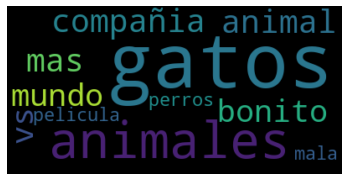

In [233]:
plt.imshow(nube_palabras, interpolation='bilinear');
plt.axis("off");

Siendo las nubes de palabras la representación más común de los datos de texto, también se podrán mostrar gráficas sobre los usuarios que publican los tweets en un gráfico de barras, mapas de calor sobre un mapa mundial mostrando las zonas donde más tweets se publican a partir de la ubicación (latitud,longitud), etc. El resto de representaciones posibles se realizarán normalmente con los datos agregados, es decir, tras analizarlos o etiquetarlos.

---
### 4.3. Aplicaciones

#### 4.3.1. Validar que las respuestas de una encuesta son válidas

Una de las posibles aplicaciones (aplicada en un proyecto nacional con una empresa de encuestas) es la validación de las respuestas en las encuestas en línea por parte de los usuarios, para verificar la integridad de las mismas, puesto que una parte de las encuestas está falseada por usuarios que no responden las mismas correctamente o acorde a su verdadera opinión. Este proyecto buscaba validar dichas respuestas con la información que se podía extraer del Twitter de cada uno de los usuarios encuestados. 

Es decir, si en una encuesta de Fútbol un fan de Messi (si así lo muestra en redes) responde negativamente a preguntas referentes sobre Messi se haría una validación cruzada entre los tweets del usuario con las respuestas de la encuesta dando lugar a una encuesta no fiable puesto que el sentimiento del usuario para/con Messi no coincide entre las respuestas de la encuesta y los tweets del usuario.

<div>
    <img src="https://i.ibb.co/7nsdxzv/trust.jpg">
</div>

#### 4.3.2. Lanzar una campaña de Twitter a usuarios que puedan estar interesados

Otra de las posibles aplicaciones es la selección o sesgo de un grupo de usuarios en base a sus tweets con el fin de determinar qué usuarios pueden estar interesados en una campaña de una categoría determinada. Es decir, supongamos que somos una empresa de Automoción que quiere lanzar una campaña en Twitter, de un conjunto de usuarios se analizaran los tweets y se pasarán como entrada a un modelo de clasificación que los clasificará, valga la redundancia, en una serie de categorías con las que el modelo ha sido entrenado.

Como se ha mencionado, se hará uso de un algoritmo de clasificación que será entrenado con un conjunto de tweets K en N categorías, donde se disponen de K/N tweets por categoría. De este modo, el algoritmo mencionado será capaz de clasificar uno o más tweets de entrada en cada una de las categorías.

In [113]:
for prediction, tweet in zip(unseen_predict, unseen['text'].tolist()):
    print("Tweet: " + tweet)
    print("Topic: " + topics[prediction])
    print("-------------------------------------------")

Tweet: La ovación a Kawhi Leonard en su regreso a Toronto.
#dormiresdecobardes
https://t.co/yTRtqhefMX
Topic: Noticias
-------------------------------------------
Tweet: Luka Doncic: "No puedes comparar a nadie con Michael Jordan. Él es único. Son sólo estadísticas". 
#GeneraciónNBA, hoy a las 22:00h en @vamos. https://t.co/IISRqlHrPg
Topic: Deportes
-------------------------------------------
Tweet: HABÍA UNA VEZ UN CIRCO....

¡El despiporre! Qué partido de Kemba Walker. #dormiresdecobardes https://t.co/74bsNPWKIF
Topic: Deportes
-------------------------------------------
Tweet: Central de rumores. 
@ICano14 nos trae los rumores más sonados de posibles traspasos. #GeneraciónNBA https://t.co/bie01J4XGo
Topic: Noticias
-------------------------------------------
Tweet: Los Pacers son un hueso duro de roer.
Victoria sobre los Celtics en un gran partido. 
#dormiresdecobardes https://t.co/5QHhWd0MaE
Topic: Deportes
-------------------------------------------
Tweet: Falló Kemba, aunque pud

#### 4.3.3. Clasificar un tweet en N categorías distintas

Supone un acercamiento más profundo a la aplicación mencionada previamente, que, en vez de utilizar un modelo de clasificación, utilizará un sistema de *Topic Modelling* que es una técnica de aprendizaje supervisado que de forma automática busca inferir un conjunto N de clusters dada una coleccion de documentos de entrada K. La agrupación de los documentos en clusters se basa en la similitud de sus características.

Existen diversos algoritmos de *Topic Modelling* entre los que destacamos: *Latent Semantic Analysis (LSA/LSI)*, *Probabilistic Latent Semantic Analysis (pLSA)* y *Latent Dirichlet Allocation (LDA)*. A continuación, se aplicará el algoritmo LDA, que es un modelo generativo probabilístico que asume que cada *topic* es una combinación sobre un conjunto de palabras subyacente y cada documento es la combinación de un conjunto de probabilidades.

Mencionar que se hace uso del paquete de Python [pyLDAvis](https://github.com/bmabey/pyLDAvis) que es una implementación en Python del paquete de R [LDAvis](https://github.com/cpsievert/LDAvis) de [Carson Sievert](https://cpsievert.me) y [Kenny Shirley](http://www.kennyshirley.com/) realizada por [Ben Mabey](https://github.com/bmabey).

Este tipo de visualización muestra la organización de los *topics* y su distribución y proximidad en base a las palabras que lo forman, de modo que en función del *topic* unas palabras tendrán más peso o relevancia que otras, determinando así a que *topic* pertenece cada uno de los documentos tal y como se ha desglosado y explicado previamente.

<div>
    <img src="https://i.ibb.co/FmbxGMh/ldavis-topic1.png">
</div>

<div>
    <img src="https://i.ibb.co/vxy3VMp/ldavis-topic2.png">
</div>

#### 4.3.4. Modelo de Análisis de Sentimientos

Mencionar también los modelos de análisis de sentimientos que determinan el sentimiento (positivo, negativo o neutral) de un tweet, lo cual es útil a la hora de estudiar el comportamiento de los usuarios para/con un tema en concreto. En este caso, tras estudiar los distintos modelos ya existentes para análisis de sentimientos se ha determinado la creación de un modelo propio de forma supervisada. Esto implica que se clasificarán tweets en sentimientos de forma manual y supervisada, de cara a pasar como entrada dichos tweets a un modelo de clasificación en categorías: positivo, negativo y neutral.

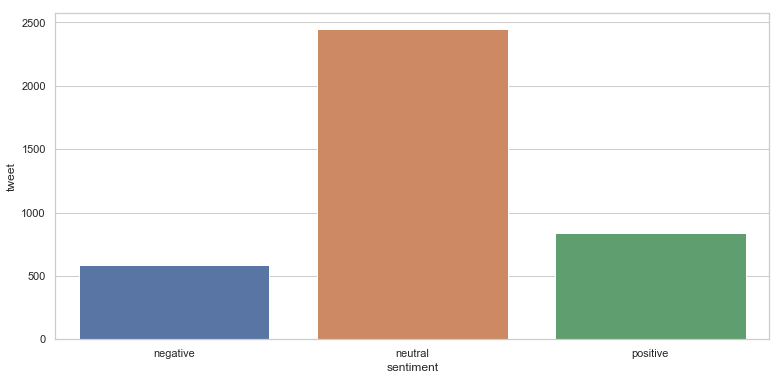

In [44]:
plt.figure(figsize=(12.8,6))

aux = df.groupby('sentiment').count()

sns.barplot(data=aux, x=aux.index, y='tweet')

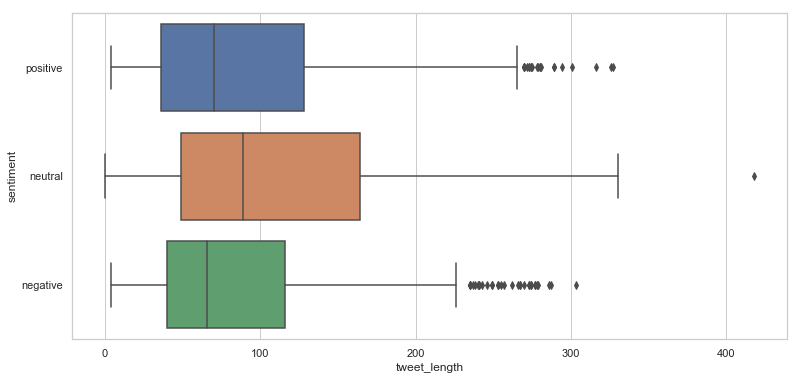

In [45]:
plt.figure(figsize=(12.8,6))

sns.boxplot(data=df, x='tweet_length', y='sentiment')

---
## 5. Conclusiones

Tras haber mostrado el funcionamiento básico del Procesamiento del Lenguaje Natural (NLP) junto con la explicación de algunas de las infinitas posibilidades que ofrece, se concluye este estudio con la gran relevancia que adquiere el análsis de texto y, más en concreto, el proveniente de las redes sociales de cara a posicionar una empresa, analizar el sector, lanzar campañas personalizadas, etc.

El uso y la inclusión de técnicas de NLP en el ámbito del negocio supone una ventaja competitiva, puesto que el análisis que se puede obtener mediante el aprendizaje máquina (*Machine Learning*) tanto supervisado como no supervisado.

---
## 6. Referencias

1. Uysal, A. K., & Gunal, S. (2014). The impact of preprocessing on text classification. Information Processing & Management, 50(1), 104-112.

---
## 7. Datos de Contacto

Correo Electrónico: **alvarob96@usal.es**

Github: **@alvarob96**

## ¡Muchas gracias por asistir!